####################

July 1st, 2025

- Joining the trans and cis into a single file
- Generating a filtered pairs file for each replicate, transforming them to coolers and then merging the coolers
- Balancing the merged coolers


Loading in some libraries

In [33]:
import sys
import gzip
import matplotlib.pyplot as plt
import numpy as np
import cooler
import pandas as pd
import cooltools

In [ ]:

def filter_pairs_by_specific_chromosomes(input_file, output_file):
    # List of chromosomes to filter
    target_chromosomes = ["2L_JJg14_439","2R_JJg14_439", "3L_JJg14_439", "3R_JJg14_439", "4_JJg14_439", "X_JJg14_439", "Y_JJg14_439", "2L_JJg14_057", "2R_JJg14_057", "3L_JJg14_057", "3R_JJg14_057", "4_JJg14_057", "X_JJg14_057", "Y_JJg14_057"]
    buffer = []
    
    buffer_size = 10000

    with gzip.open(input_file, 'rt') as infile, gzip.open(output_file, 'wt') as outfile:
        for line in infile:
            if line.startswith("#"):  # Process header lines
                # Check if the header line starts with any of the target chromosomes
                if line.startswith("#chromsize"):
                    parts = line.strip().split(" ")
                    if parts[1] in target_chromosomes:
                        #create a new chromosome trans and add it to the header
                        line = line.replace("_JJg14_057", "_trans")
                        line = line.replace("_JJg14_439", "_trans")
                        buffer.append(line)
                        #and then replace trans with nothing and add the sis chromosomes to header
                        line = line.replace("_trans", "")
                        buffer.append(line)
                elif line.startswith("#samheader: @SQ"):
                    parts = line.strip().split(":")
                    parts2 = parts[2].strip().split("LN")
                    if parts2[0].strip() in target_chromosomes:
                        line = line.replace("_JJg14_057", "_trans")
                        line = line.replace("_JJg14_439", "_trans")
                        buffer.append(line)
                        line = line.replace("_trans", "")
                        buffer.append(line)
                else:
                    buffer.append(line)

                outfile.writelines(buffer)
                buffer=[]
                continue
            parts = line.strip().split("\t")
            # Check if both parts[1] and parts[3] are in the target chromosomes list
            if parts[1] in target_chromosomes and parts[3] in target_chromosomes:
                
                if parts[1] == parts[3]:
                    line = line.replace("_JJg14_057", "")
                    line = line.replace("_JJg14_439", "")
                else:
                    line = line.replace("_JJg14_057", "_trans")
                    line = line.replace("_JJg14_439", "_trans")
                
                buffer.append(line)
      
                if len(buffer) >= buffer_size:
                    outfile.writelines(buffer)
                    buffer=[]

        
        
input_file1 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.pairs.gz"
input_file2 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004896_PnM2.pairs.gz"
input_file3 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004897_PnM3.pairs.gz"
output_file1 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.filt.pairs.gz"
output_file2 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004896_PnM2.filt.pairs.gz"
output_file3 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004897_PnM3.filt.pairs.gz"
  
filter_pairs_by_specific_chromosomes(input_file1, output_file1)
filter_pairs_by_specific_chromosomes(input_file2, output_file2)
filter_pairs_by_specific_chromosomes(input_file3, output_file3)


From pairs to merged cool

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ 

cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/processing4/erikson_pipegrp/Jumana_nextflow/dm6_genome.reduced.chromsizes:20000 24L004895_PnM1.filt.pairs.gz 24L004895_PnM1.filt.pairs.cool

cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/processing4/erikson_pipegrp/Jumana_nextflow/dm6_genome.reduced.chromsizes:20000 24L004896_PnM2.filt.pairs.gz 24L004896_PnM2.filt.pairs.cool

cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/processing4/erikson_pipegrp/Jumana_nextflow/dm6_genome.reduced.chromsizes:20000 24L004897_PnM3.filt.pairs.gz 24L004897_PnM3.filt.pairs.cool

cooler merge 20250611_PnMs_merged.cool 24L004895_PnM1.filt.pairs.cool 24L004896_PnM2.filt.pairs.cool 24L004897_PnM3.filt.pairs.cool 




Some QC

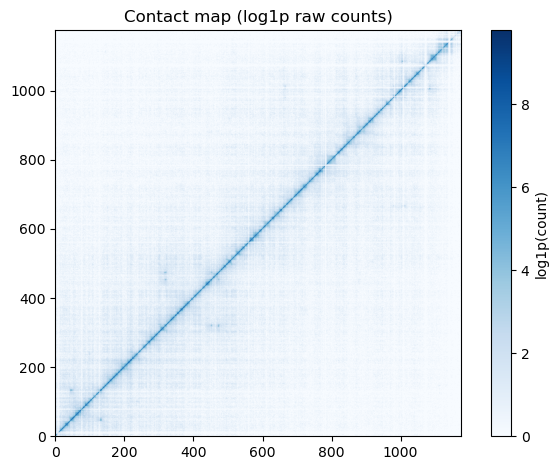

In [34]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.filt.pairs.cool")

# Example: plot chromosome 2L (you can adjust)
mat = clr.matrix(balance=False).fetch("2L")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts)")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Contact distance decay

INFO:root:creating a Pool of 2 workers
/tmp/ipykernel_52834/2305662963.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['dist'] < 2] = np.nan


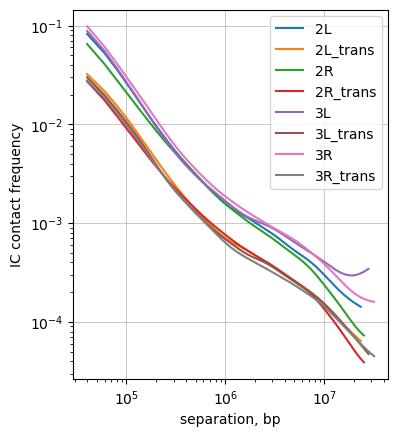

In [32]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.filt.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2
    )

# filter short distances
cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['dist'] < 2] = np.nan

# plot
fig, ax = plt.subplots(1,1)

for region in chromsizes['chrom']:
    ax.loglog(
        cvd_smooth_agg['dist_bp'].loc[cvd_smooth_agg['region1']==region],
        cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['region1']==region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

ax.legend(chromsizes['chrom'], loc='upper right')

Taking a look at the merged cooler

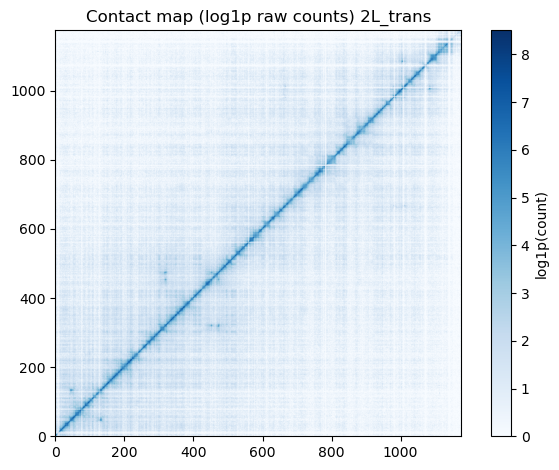

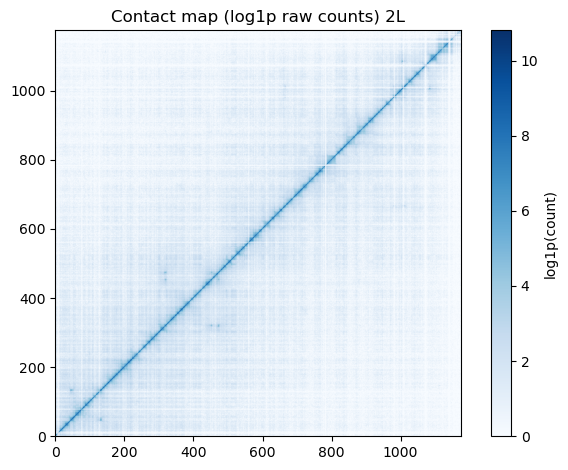

In [47]:
import cooler
import matplotlib.pyplot as plt
import numpy as np

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_merged.cool")

mat = clr.matrix(balance=False).fetch("2L_trans")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) 2L_trans")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=False).fetch("2L")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) 2L")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Dropping all of the NaNs from the matrix

In [36]:
# Load cooler file
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_merged.cool")

# Compute expected contact frequency from raw counts
expected = expected_cis(clr, clr_weight_name=None)

# Drop rows with any NaN values
expected_filtered = expected.dropna()

# Optional: reset index if needed
expected_filtered.reset_index(drop=True, inplace=True)

# Print the result
print(expected_filtered.head())

  region1 region2  dist  dist_bp  contact_frequency  n_total  n_valid  \
0      2L      2L     2    40000         194.958295     1174     1174   
1      2L      2L     3    60000         125.770503     1173     1173   
2      2L      2L     4    80000          87.261844     1172     1172   
3      2L      2L     5   100000          64.644148     1171     1171   
4      2L      2L     6   120000          50.110954     1170     1170   

   count.sum   count.avg  count.avg.smoothed  count.avg.smoothed.agg  
0   421015.0  358.615843          329.689738              194.958295  
1   257306.0  219.357204          212.799873              125.770503  
2   179033.0  152.758532          147.835846               87.261844  
3   132535.0  113.181042          109.308230               64.644148  
4   101072.0   86.386325           84.314156               50.110954  


Does the matrxi still look ok

In [37]:
import cooler
import pandas as pd

# Load the cooler file
cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_merged.cool"
clr = cooler.Cooler(cool_path)

chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/dm6_genome.reduced.chromsizes"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

print(chromsizes.head())

# Drop rows with NaN values from the bins table
bins = clr.bins()[:]
filtered_bins = bins.dropna()

# Get the indices of the filtered bins
filtered_bin_indices = filtered_bins.index

# Filter the pixel table to exclude interactions involving removed bins
pixels = clr.pixels()[:]
filtered_pixels = pixels[
    pixels["bin1_id"].isin(filtered_bin_indices) & pixels["bin2_id"].isin(filtered_bin_indices)
]

# Save the filtered data back to a new cooler file
output_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool"
cooler.create_cooler(
    output_path,
    bins=filtered_bins,
    pixels=filtered_pixels,
    metadata={"chromsizes": dict(zip(chromsizes["chrom"], chromsizes["size"]))}  # Add chromsizes to metadata
)

print(f"Filtered cooler saved to {output_path}")

      chrom      size
0        2L  23513712
1  2L_trans  23513712
2        2R  25286936
3  2R_trans  25286936
4        3L  28110227
Filtered cooler saved to /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool


See how the filtered cooler looks like

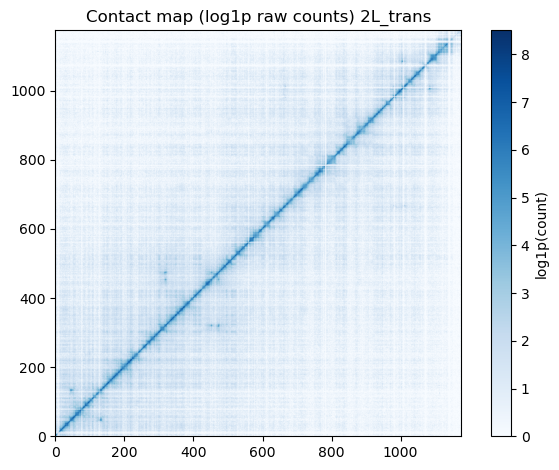

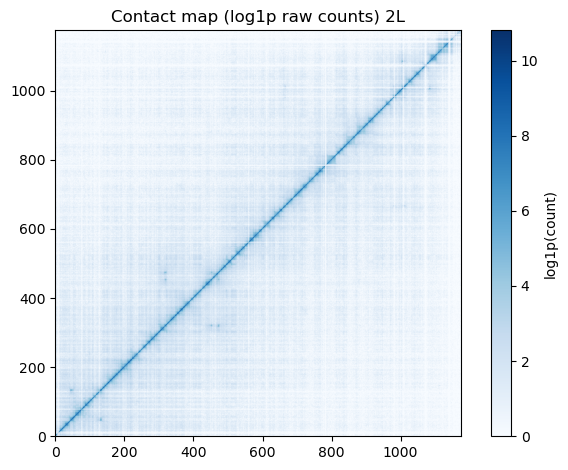

In [38]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool")

mat = clr.matrix(balance=False).fetch("2L_trans")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) 2L_trans")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=False).fetch("2L")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) 2L")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()


Balancing the  filtered cooler

In [40]:
cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool"
balanced_cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250702_20250611_PnMs_filtered_cisTrans.cool"

chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/dm6_genome.reduced.chromsizes"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler(cool_path)

mat = clr.matrix(balance=False).fetch("2L_trans")
print("NaNs present:", np.isnan(mat).any())
print("Zeros on diagonal:", np.any(np.diag(mat) == 0))
print("Rows with all zeros:", np.sum(np.all(mat == 0, axis=1)))
print("Cols with all zeros:", np.sum(np.all(mat == 0, axis=0)))

# Run balancing
weights, stats = cooler.balance_cooler(clr, max_iters=1000, tol=1e-5)

print("Balancing stats:", stats)
print("Weights head:", weights[:10])

# Attach weights to the bins table
bins = clr.bins()[:]
bins["weight"] = weights  



# Save the balanced cooler file
cooler.create_cooler(
    balanced_cool_path,
    bins=bins,
    pixels=clr.pixels()[:],
    metadata={"chromsizes": dict(zip(chromsizes["chrom"], chromsizes["size"]))}  # Add chromsizes to metadata
)

print(f"Balanced cooler saved to {balanced_cool_path}")

clr_cool = cooler.Cooler(balanced_cool_path)
print(clr_cool.info)

NaNs present: False
Zeros on diagonal: True
Rows with all zeros: 0
Cols with all zeros: 0


/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/cooler/balance.py:113: ConvergenceWarning: Iteration limit reached without convergence.
  warnings.warn(


Balancing stats: {'tol': 1e-05, 'min_nnz': 10, 'min_count': 0, 'mad_max': 5, 'cis_only': False, 'ignore_diags': 2, 'scale': 8.675991944690509e+247, 'converged': False, 'var': inf, 'divisive_weights': False}
Weights head: [0.04579236 0.0515316  0.03143754 0.03577338 0.02961034 0.02104442
        nan 0.10786663 0.12171207        nan]
Balanced cooler saved to /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250702_20250611_PnMs_filtered_cisTrans.cool
{'bin-size': 20000, 'bin-type': 'fixed', 'creation-date': '2025-07-02T14:49:19.737079', 'format': 'HDF5::Cooler', 'format-url': 'https://github.com/open2c/cooler', 'format-version': 3, 'generated-by': 'cooler-0.10.2', 'genome-assembly': 'unknown', 'metadata': {'chromsizes': {'2L': 23513712, '2L_trans': 23513712, '2R': 25286936, '2R_trans': 25286936, '3L': 28110227, '3L_trans': 28110227, '3R': 32079331, '3R_trans': 32079331, '4': 1348131, '4_trans': 1348131, 'X': 23542271, 'X_trans': 23542271, 'Y': 3667352, 'Y_trans': 3667352}}, 'nbins':

Can we balance a cooler without the extra contigs but chromosome names are unchanged (no cis/trans separation)

In [43]:
cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250702_24L004895_PnM1.filt.cool"
balanced_cool_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250702_24L004895_PnM1.filt.balanced.cool"

chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/diploid_genome.chromsizes"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler(cool_path)

mat = clr.matrix(balance=False).fetch("2L_JJg14_057")
print("NaNs present:", np.isnan(mat).any())
print("Zeros on diagonal:", np.any(np.diag(mat) == 0))
print("Rows with all zeros:", np.sum(np.all(mat == 0, axis=1)))
print("Cols with all zeros:", np.sum(np.all(mat == 0, axis=0)))

# Run balancing
weights, stats = cooler.balance_cooler(clr, max_iters=1000, tol=1e-5)

print("Balancing stats:", stats)
print("Weights head:", weights[:10])

# Attach weights to the bins table
bins = clr.bins()[:]
bins["weight"] = weights  



# Save the balanced cooler file
cooler.create_cooler(
    balanced_cool_path,
    bins=bins,
    pixels=clr.pixels()[:],
    metadata={"chromsizes": dict(zip(chromsizes["chrom"], chromsizes["size"]))}  # Add chromsizes to metadata
)

print(f"Balanced cooler saved to {balanced_cool_path}")

clr_cool = cooler.Cooler(balanced_cool_path)
print(clr_cool.info)

NaNs present: False
Zeros on diagonal: True
Rows with all zeros: 1
Cols with all zeros: 1


/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localenv/erikson/anaconda/envs/PoreC/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Balancing stats: {'tol': 1e-05, 'min_nnz': 10, 'min_count': 0, 'mad_max': 5, 'cis_only': False, 'ignore_diags': 2, 'scale': 7922.213346203984, 'converged': True, 'var': 8.629254038857258e-06, 'divisive_weights': False}
Weights head: [0.04093885 0.03806575 0.0227701  0.02807713 0.02292602 0.01506983
        nan 0.08569459 0.09041954        nan]
Balanced cooler saved to /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250702_24L004895_PnM1.filt.balanced.cool
{'bin-size': 20000, 'bin-type': 'fixed', 'creation-date': '2025-07-02T15:06:26.684141', 'format': 'HDF5::Cooler', 'format-url': 'https://github.com/open2c/cooler', 'format-version': 3, 'generated-by': 'cooler-0.10.2', 'genome-assembly': 'unknown', 'metadata': {'chromsizes': {'2L_JJg14_057': 23513712, '2R_JJg14_057': 25286936, '3L_JJg14_057': 28110227, '3R_JJg14_057': 32079331, '4_JJg14_057': 1348131, 'X_JJg14_057': 23542271, 'Y_JJg14_057': 3667352, 'dmel_mitochondrion_genome_JJg14_057': 19517, 'Unmapped_Scaffold_8_JJg14_057': 8

It doesn't seem to be a problem, let's see how the matrix looks like

Matrix stats:
Max value: 8698
Min value: 0
NaNs present: False
Rows with all zeros: 1
Columns with all zeros: 1


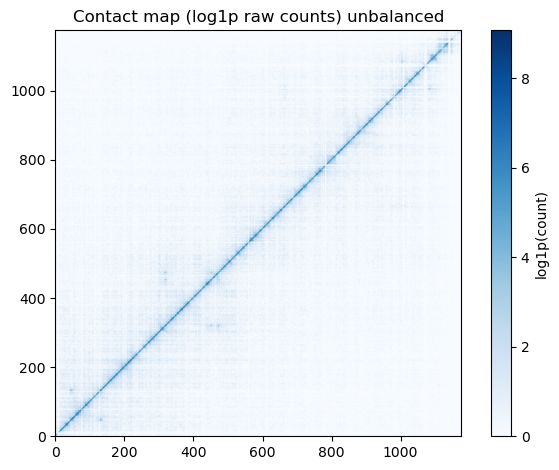

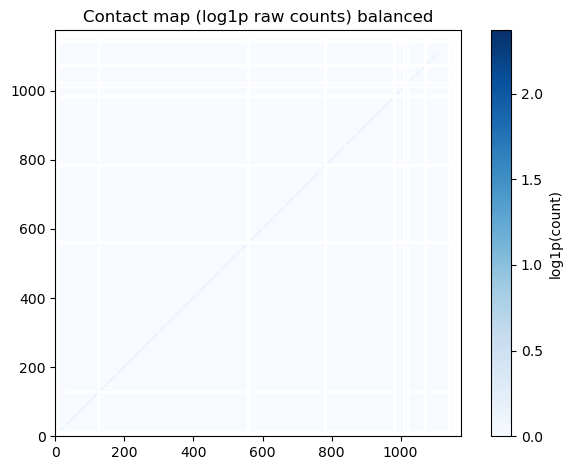

In [44]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250702_24L004895_PnM1.filt.balanced.cool")

mat = clr.matrix(balance=False).fetch("2L_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) unbalanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2L_JJg14_057")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Extracting the abnormally low and abnormally high region and then blacklisting those regions

In [46]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250611_PnMs_filtered.cool")
bins = clr.bins()[:]
bin_size = clr.info['bin-size']  


# Compute per-bin coverage (sum of contacts for each bin)
matrix = clr.matrix(balance=False)[:]
coverage = matrix.sum(axis=0)  # Sum contacts for each bin


# Define thresholds
low_thresh = np.percentile(coverage[coverage > 0], 2)  # 2nd percentile (excluding 0s)
high_thresh = np.percentile(coverage, 99)              # 99th percentile (extreme high)

# Mask bins
low_coverage_mask = (coverage <= low_thresh) | (coverage == 0)
high_coverage_mask = (coverage >= high_thresh)

# Combine masks
blacklist_mask = low_coverage_mask | high_coverage_mask
blacklisted_bins = bins[blacklist_mask]

# Export to BED
bed = blacklisted_bins[['chrom', 'start', 'end']]
bed.to_csv("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/drosophila_blacklist_cisTrans.bed", sep='\t', header=False, index=False)

# Optional: Print stats
print(f"Total bins: {len(bins)}")
print(f"Low coverage bins: {np.sum(low_coverage_mask)}")
print(f"High coverage bins: {np.sum(high_coverage_mask)}")
print(f"Total blacklisted bins: {len(bed)}")

Total bins: 13762
Low coverage bins: 1179
High coverage bins: 138
Total blacklisted bins: 1317


I try to balance with the blacklisting the regions above and the matrix doesn't converge:
(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$  cooler balance 20250611_PnMs_filtered.cool --blacklist drosophila_blacklist_cisTrans.bed --mad-max 5 --min-nnz 10 --max-iters 10000 --tol 1e-4

INFO:cooler.cli.balance:Balancing "20250611_PnMs_filtered.cool"

INFO:cooler.balance:variance is 11288981.349711271

INFO:cooler.balance:variance is 8202300305.376032

INFO:cooler.balance:variance is 32171605.306783494

INFO:cooler.balance:variance is 75509734954.79631

INFO:cooler.balance:variance is 235601008.05455628

...

INFO:cooler.balance:variance is inf

INFO:cooler.balance:variance is 4.209322814315788e+302

INFO:cooler.balance:variance is inf

INFO:cooler.balance:variance is 3.8264777941331394e+303

INFO:cooler.balance:variance is inf

INFO:cooler.balance:variance is inf

